Install dependencies

In [1]:
#!pip install mediapipe sklearn tensorflow tensorflow-gpu opencv-python matplotlib

In [24]:
!pip list

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
import tensorflow as tf
import os
import mediapipe as mp

In [4]:
mp_holistic = mp.solutions.holistic     #Holistic model
mp_drawing = mp.solutions.drawing_utils #Drawing utilities

In [5]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Color conversion
    image.flags.writeable = False
    results = model.process(image)                 # Prediction
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Color reversion
    return image,results

In [6]:
#Draw faces,pose and hand connections
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    

In [7]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                                mp_drawing.DrawingSpec(color=(204, 0, 204), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(51, 153, 0), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(204, 0, 204), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(51, 153, 0), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(204, 0, 204), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(51, 153, 0), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(204, 0, 204), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(51, 153, 0), thickness=1, circle_radius=1))

In [6]:
cap = cv2.VideoCapture(0)

#Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)        

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        #Break loop
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [7]:
len(results.pose_landmarks.landmark)

33

In [8]:
draw_styled_landmarks(frame, results)

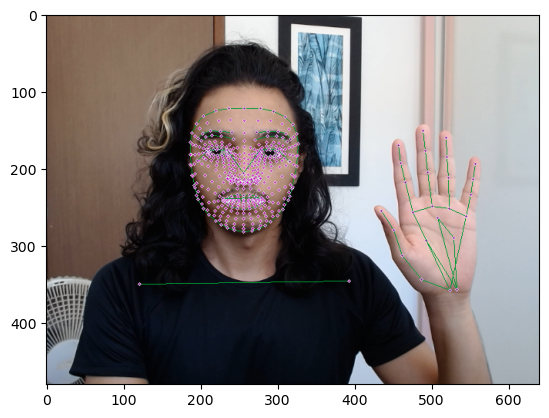

In [9]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [23]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    leftHand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rightHand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face,leftHand,rightHand])

In [24]:
result_test = extract_keypoints(results) #Checking results

In [25]:
result_test

array([ 0.42641705,  0.65740097, -1.34452975, ...,  0.        ,
        0.        ,  0.        ])

In [13]:
np.save('0',result_test)

In [12]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_DATA')

# Actions that we try to detect
actions = np.array(['Ola', 'Obrigado','EuTeAmo','SemInput'])

# Thirty videos worth of data
no_sequences = 30

# Size in frames per video
sequence_length = 30


In [15]:
#Folder Creation with the actions on it
for action in actions:  
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [16]:
cap = cv2.VideoCapture(0)

#Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        
        #loop through actions
        for action in actions:
            for sequence in range (no_sequences):
                #Loop through video length
                for frame_num in range(sequence_length):                    

                    # Read feed
                    ret, frame = cap.read()
                    
                    # Make detections
                    image, results = mediapipe_detection(frame, holistic)

                    # Draw landmarks
                    draw_styled_landmarks(image, results)                   
                    
                    if frame_num == 0:
                        #Modelling format
                        cv2.putText(image, 'Iniciando Coleta', (120,200),
                                   cv2.FONT_HERSHEY_SIMPLEX, 1 , (0,255,124),2,cv2.LINE_AA)
                        cv2.putText(image, 'Coletando {} frames para o video {}'.format(action,sequence), (15,12),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,255,0),1,cv2.LINE_AA)
                        
                        #Wait time of half second
                        cv2.waitKey(500)
                        
                    else:
                         cv2.putText(image, 'Coletando frames para {} Video Num: {}'.format(action,sequence), (15,12),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,255,0),1,cv2.LINE_AA)
                    
                    #Save data on folders
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(DATA_PATH, action,str(sequence),str(frame_num))
                    np.save(npy_path, keypoints)
                    
                    
                    #Showing the results
                    cv2.imshow('OpenCV Feed',image)

                    #Break loop
                    if cv2.waitKey(10) & 0xFF == ord('q'):
                        break
    cap.release()
    cv2.destroyAllWindows()

KeyboardInterrupt: 

In [9]:
#!pip install -U scikit-learn
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [18]:
label_map = {label:num for num,label in enumerate(actions)}

In [19]:
sequences, labels = [],[]
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [20]:
X = np.array(sequences)

In [21]:
X.shape

(120, 30, 1662)

In [22]:
y = to_categorical(labels).astype(int)

In [ ]:
X_train, X_test, y_train , y_test = train_test_split(X,y,test_size=0.05)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Input
from tensorflow.keras.callbacks import TensorBoard

In [33]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir = log_dir)

In [13]:
model = Sequential()
model.add(Input(shape=(30,1662)))
#model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))


In [35]:
model.compile(optimizer='Adam', loss='categorical_crossentropy' , metrics=['categorical_accuracy'])

In [36]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - categorical_accuracy: 0.2504 - loss: 4.9256
Epoch 2/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.2734 - loss: 19.6945
Epoch 3/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.2180 - loss: 48.5572
Epoch 4/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.2793 - loss: 10.3740
Epoch 5/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.2497 - loss: 23.9074
Epoch 6/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.2734 - loss: 10.5250
Epoch 7/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.1731 - loss: 12.0226
Epoch 8/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.2069 - loss: 32.0547
Epoch 9/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.3156 - loss: 17.7859
Epoch 10/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_accuracy: 0.1962 - loss: 35.8865
Epoch 11/2000
4/4 ━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.7012 - loss: 0.8246
Epoch 64/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.7458 - loss: 0.6427
Epoch 65/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.7343 - loss: 0.7091
Epoch 66/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.7674 - loss: 0.6480
Epoch 67/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.8286 - loss: 0.5534
Epoch 68/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.5599 - loss: 1.1047
Epoch 69/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.6928 - loss: 0.6503
Epoch 70/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.8046 - loss: 0.5459
Epoch 71/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.8594 - loss: 0.4578
Epoch 72/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.8884 - loss: 0.3784
Epoch 73/2000
4/4 ━━━━━━━━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.4116 - loss: 1.5345
Epoch 125/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.3675 - loss: 1.8835
Epoch 126/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.4112 - loss: 1.4466
Epoch 127/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.4599 - loss: 1.2314
Epoch 128/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.4763 - loss: 1.5480
Epoch 129/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.4671 - loss: 1.2505
Epoch 130/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.6278 - loss: 1.0910
Epoch 131/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.3745 - loss: 1.3462
Epoch 132/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.3730 - loss: 3.7999
Epoch 133/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.1734 - loss: 19.8100
Epoch 134/2000
4/4 ━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 517ms/step - categorical_accuracy: 0.5562 - loss: 1.2296
Epoch 186/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.5401 - loss: 1.1926
Epoch 187/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.5374 - loss: 1.1996
Epoch 188/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.4928 - loss: 1.2212
Epoch 189/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.5388 - loss: 1.1764
Epoch 190/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.4749 - loss: 1.1886
Epoch 191/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.5946 - loss: 1.1335
Epoch 192/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.4853 - loss: 1.1569
Epoch 193/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - categorical_accuracy: 0.5031 - loss: 1.1555
Epoch 194/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.4963 - loss: 1.1753
Epoch 195/2000
4/4 ━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.7133 - loss: 0.6801
Epoch 247/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.7215 - loss: 0.6775
Epoch 248/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.8258 - loss: 0.5827
Epoch 249/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.7691 - loss: 0.6502
Epoch 250/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.7393 - loss: 0.6356
Epoch 251/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.6676 - loss: 0.7561
Epoch 252/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.7287 - loss: 0.6687
Epoch 253/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.6711 - loss: 0.7385
Epoch 254/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_accuracy: 0.7973 - loss: 0.5675
Epoch 255/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.8004 - loss: 0.6057
Epoch 256/2000
4/4 ━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.8366 - loss: 0.5041
Epoch 308/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.8439 - loss: 0.4528
Epoch 309/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.8414 - loss: 0.4784
Epoch 310/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.7814 - loss: 0.5405
Epoch 311/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.9277 - loss: 0.3192
Epoch 312/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.8514 - loss: 0.3685
Epoch 313/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.9249 - loss: 0.3099
Epoch 314/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.8974 - loss: 0.3075
Epoch 315/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.8832 - loss: 0.3213
Epoch 316/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.8466 - loss: 0.4056
Epoch 317/2000
4/4 ━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.7059 - loss: 0.7611
Epoch 369/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.6564 - loss: 0.9945
Epoch 370/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.6780 - loss: 0.7581
Epoch 371/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.6686 - loss: 0.8076
Epoch 372/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.5360 - loss: 0.6856
Epoch 373/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.8577 - loss: 0.4232
Epoch 374/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.8674 - loss: 0.3130
Epoch 375/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.9428 - loss: 0.2912
Epoch 376/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.8856 - loss: 0.2847
Epoch 377/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.8748 - loss: 0.3196
Epoch 378/2000
4/4 ━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.8765 - loss: 0.2466
Epoch 430/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.9442 - loss: 0.1604
Epoch 431/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.9571 - loss: 0.1647
Epoch 432/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.9888 - loss: 0.1245
Epoch 433/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_accuracy: 0.9589 - loss: 0.1828
Epoch 434/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.9435 - loss: 0.1316
Epoch 435/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.9554 - loss: 0.1293
Epoch 436/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.9508 - loss: 0.1582
Epoch 437/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.9647 - loss: 0.1393
Epoch 438/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.9689 - loss: 0.1264
Epoch 439/2000
4/4 ━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.8146 - loss: 0.4365
Epoch 491/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.8979 - loss: 0.3240
Epoch 492/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.9215 - loss: 0.2083
Epoch 493/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.9163 - loss: 0.3087
Epoch 494/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - categorical_accuracy: 0.9676 - loss: 0.1582
Epoch 495/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.9703 - loss: 0.1252
Epoch 496/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.9801 - loss: 0.1167
Epoch 497/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.9794 - loss: 0.1279
Epoch 498/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - categorical_accuracy: 0.9794 - loss: 0.0901
Epoch 499/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.9930 - loss: 0.0878
Epoch 500/2000
4/4 ━━━━━━

KeyboardInterrupt: 

In [37]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 30, 128)             │         916,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,918,318 (11.13 MB)

 Trainable params: 972,772 (3.71 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,945,546 (7.42 MB)

In [ ]:
res = model.predict(X_test)

In [57]:
actions[np.argmax(res[3])]

'SemInput'

In [58]:
actions[np.argmax(y_train[3])]

'EuTeAmo'

In [60]:
model.save('blindTest.keras')

Reminder to Reload model
Re-Run Model Sequential
Re-compile it
and then

Model.load_weights('name_of_saved_model')

In [14]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [15]:
model.load_weights('blindTest.keras')

In [ ]:
yhat = model.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [66]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[3, 0],
        [0, 3]],

       [[5, 0],
        [0, 1]],

       [[5, 0],
        [0, 1]],

       [[5, 0],
        [0, 1]]], dtype=int64)

In [ ]:
accuracy_score(ytrue,yhat)

In [21]:
colors = [(245,117,16), (117,245,16), (16,117,245),(216,191,216)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [27]:
# 1. New detection variables
sequence, sentence, predictions = [], [], []

threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break Loop
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
SemInput
<class 'mediapipe

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Ola
<class 'mediapipe.python.solution_bas

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
EuTeAmo
<class 'mediapipe.python.so

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EuTeAmo
<class 'mediapipe.python.so

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
EuTeAmo
<class 'mediapipe.python.so

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
EuTeAmo
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Ola
<class 'mediapipe.python.solution_b

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.pyth

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
SemInput
<class 'mediapipe

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
SemInput
<class 'mediapipe

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Obrigado
<class 'mediapipe.pyth

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solutio

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Obrigado
<class 'mediapipe

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Obrigado
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Obrigado
<class 'mediapipe

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Ola
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.Sol

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
SemInput
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
SemInput
<class 'mediapipe